In [1]:
import sys
sys.path.insert(0,'/home/jovyan/work/src/')
from sqlalchemy import create_engine, MetaData, select
from sqlalchemy.orm import sessionmaker
from arise.barcode.metadata.orm.barcode import Barcode
from arise.barcode.metadata.orm.marker import Marker
from arise.barcode.metadata.orm.nsr_species import NsrSpecies
from arise.barcode.metadata.orm.nsr_synonym import NsrSynonym
from arise.barcode.metadata.orm.nsr_node import NsrNode
from arise.barcode.metadata.orm.specimen import Specimen
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
engine = create_engine('sqlite:////home/jovyan/work/data/sqlite/arise-barcode-metadata_old.db', echo=False)

# make session
Session = sessionmaker(engine)
session = Session()

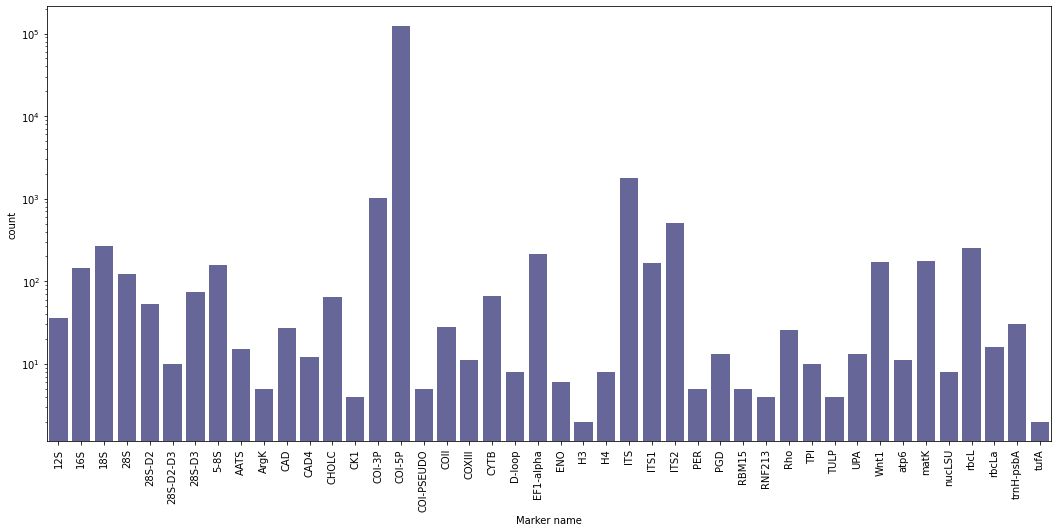

In [3]:
# with relationship()
# nsr_barcodes = session.query(Barcode).all()
# data = [el.marker.marker_name for el in nsr_barcodes]

# without?
markers = session.query(Barcode.marker_id, Marker.marker_name).join(Marker).all()
data = [el[1] for el in markers]
df = pd.DataFrame(data, columns=['Marker name']).sort_values(by=['Marker name'])
fig, ax = plt.subplots(figsize=(18,8))
sb.countplot(data=df, x='Marker name', ax=ax, color='b', saturation=0.2)
ax.set_yscale('log')
ax.tick_params(axis="x", rotation=90)

<AxesSubplot:xlabel='count', ylabel='Institution'>

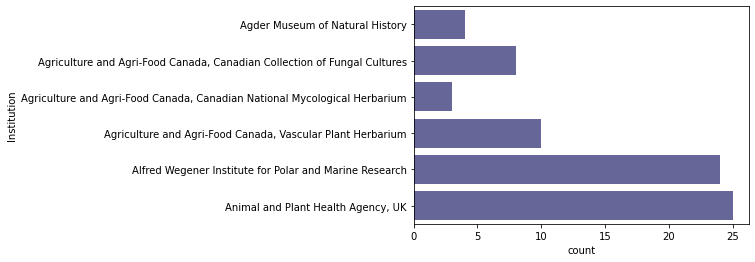

In [4]:
institutions = session.query(Specimen.institution_storing).limit(100).all()
institutions = [e[0] for e in institutions if e[0]]
df = pd.DataFrame(institutions, columns=['Institution']).sort_values(by=['Institution'])
sb.countplot(data=df, y='Institution', color='b', saturation=0.2)

In [7]:
res = session.query(NsrNode).filter(NsrNode.id == 15).first()
print(res.get_children(session))
NsrNode.get_root(session)

SELECT node.id AS node_id, node.parent AS node_parent, node."left" AS node_left, node."right" AS node_right, node.name AS node_name, node.length AS node_length, node.height AS node_height, node.rank AS node_rank, node.species_id AS node_species_id 
FROM node 
WHERE node.parent = ?


<NsrNode(name='2')>